In [5]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale = 1)
import os

import math
from pytorch_pretrained_bert import BertTokenizer
os.chdir('C:\\Users\\ntaylor\\Documents\\GitHub\\Neural_Networks\\NLP\\clinicalBERT')
from modeling_readmission import BertForSequenceClassification, BertForSequenceClassification_3layer
import modeling_readmission

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

05/12/2021 14:23:28 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\ntaylor\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


'C:\\Users\\ntaylor\\Documents\\GitHub\\Neural_Networks\\NLP\\clinicalBERT'

In [20]:

model_1layer_discharge_config_path = "./model/newest_ClinicalBERTPretained_discharge_210421/config.json"
model_1layer_discharge_model_path = "./model/newest_ClinicalBERTPretained_discharge_210421/pytorch_model.bin"

model_3layer_discharge_config_path = "./model/newest_3layerClinicalBERTPretained_discharge_210421/config.json"
model_3layer_discharge_config_path = "./model/newest_3layerClinicalBERTPretained_discharge_210421/pytorch_model.bin"

In [10]:
#load 1layer model
bert_config = modeling_readmission.BertConfig.from_json_file(model_1layer_discharge_config_path)
model = BertForSequenceClassification(bert_config, num_labels = 1)

# #load 3layer model
# bert_config2 = modeling_readmission.BertConfig.from_json_file('./model/discharge_readmission/bert_config.json')

In [8]:
bert_config

{
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [6]:
bert_config.num_attention_heads

12

In [11]:
dicts=model.load_state_dict(torch.load(model_1layer_discharge_model_path))

In [12]:
dicts

<All keys matched successfully>

In [13]:
model.bert.encoder.layer[0].attention.self

BertSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [14]:
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [15]:
def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.bert.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.bert.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(bert_config,outputs_query[0])
    key_layer = transpose_for_scores(bert_config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(bert_config.hidden_size / bert_config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized

In [16]:
text=' he has experienced acute on chronic diastolic heart failure in the setting of volume overload due to his sepsis.'
x,tokens=get_attention_scores(model,0,text)
print(x)
print(tokens)

tensor([[[[4.3529e-02, 3.6868e-02, 4.1084e-02,  ..., 2.8575e-02,
           2.4518e-02, 3.9357e-02],
          [6.8513e-02, 3.2952e-02, 5.3718e-02,  ..., 2.1451e-02,
           8.6254e-03, 1.3132e-02],
          [7.2308e-02, 6.6520e-02, 3.5862e-02,  ..., 3.6128e-02,
           1.5984e-02, 2.1833e-02],
          ...,
          [1.9199e-02, 2.9894e-02, 5.0849e-02,  ..., 1.7349e-02,
           1.6054e-02, 1.3963e-02],
          [4.5357e-02, 3.4545e-02, 5.3173e-02,  ..., 5.7270e-02,
           6.8096e-03, 1.6421e-02],
          [6.1073e-02, 3.4533e-02, 9.4663e-02,  ..., 2.6712e-02,
           1.3330e-02, 2.3776e-02]],

         [[8.3789e-02, 9.9487e-03, 1.7524e-02,  ..., 8.8049e-03,
           2.9406e-02, 4.7544e-03],
          [4.1080e-04, 1.3131e-02, 9.2131e-02,  ..., 2.8889e-02,
           5.5598e-02, 1.2582e-03],
          [1.9884e-03, 3.2946e-02, 1.9110e-02,  ..., 2.2547e-02,
           4.3203e-02, 2.1409e-03],
          ...,
          [1.4245e-02, 6.8588e-02, 2.4858e-02,  ..., 2.0107

In [17]:
map1=np.asarray(x[0][1].detach().numpy())
len(tokens)

24

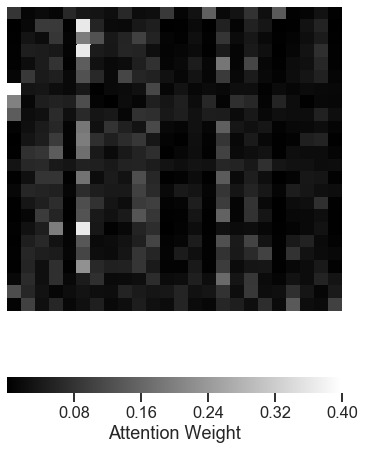

In [18]:
f, ax = plt.subplots(figsize=(6,8))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmax=0.4, cmap='gray', cbar_kws={'label':'Attention Weight', 'orientation':'horizontal'}, rasterized = True)

<Figure size 432x288 with 0 Axes>

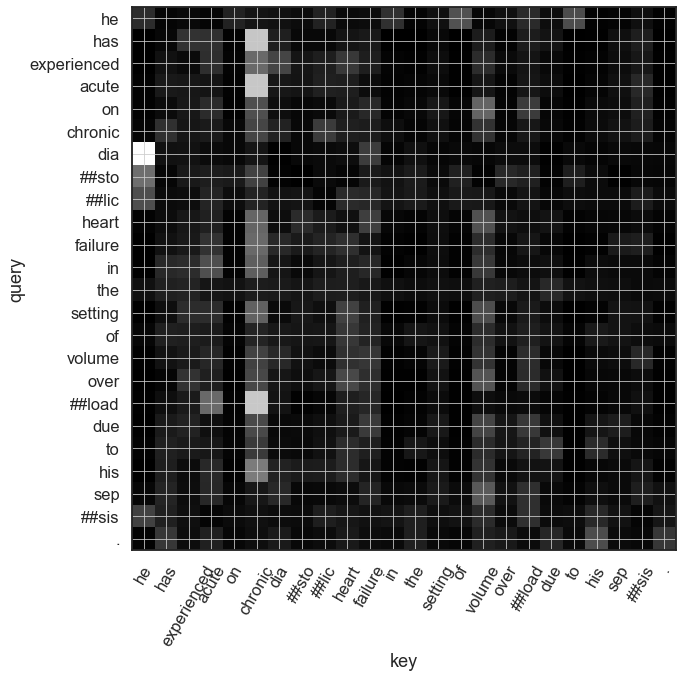

In [19]:
plt.clf()

f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='gray')

ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens,rotation=60)

ax.set_xlabel('key')
ax.set_ylabel('query')

ax.grid(linewidth = 0.8)

In [ ]:
text = 'confidential notes from mimic iii'
x,tokens=get_attention_scores(model,0,text)
map1=np.asarray(x[0][1].detach().numpy())

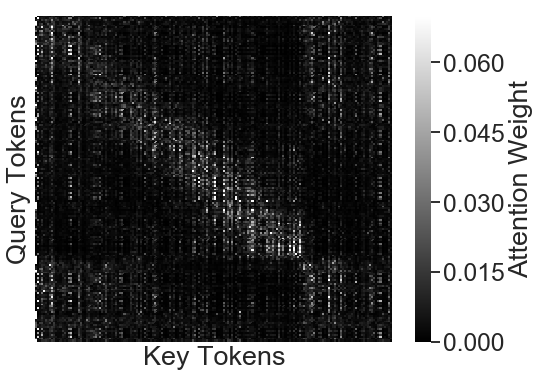

In [112]:
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmin=0, vmax=0.07, cmap='gray', cbar_kws={'label':'Attention Weight'})

ax.set_xlabel('Key Tokens')
ax.set_ylabel('Query Tokens')